# Génération d'une consigne en température pour la chambre thermostatique

Le logiciel AtmoCONTROL ne permet de consigner la température de la chambre thermostatique qu'avec des rampes affines. Ce script Python a pour objectif de générer des consignes (en rampes) approximant une consigne plus complexe, par exemple sinusoïdale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def piecewise_approximation(f, t_points, t):
    """
    Compute the piecewise linear approximation at t,
    using the segments defined by t_points.
    """
    # Sort t_points to ensure correct segment order
    t_points = np.sort(t_points)
    # Compute y_points as rounded values of the original function
    y_points = np.round(f(t_points))

    # Find the segment containing t
    i = np.searchsorted(t_points, t, side='right') - 1
    i = np.clip(i, 0, len(t_points) - 2)

    # Linear interpolation between the two closest points
    t0, t1 = t_points[i], t_points[i + 1]
    y0, y1 = y_points[i], y_points[i + 1]

    return y0 + (y1 - y0) * (t - t0) / (t1 - t0)

def optimize_t(f, duration, N):
    # Initial guess
    t0 = np.linspace(0, duration, N)
    # Sample points for error calculation (fine grid)
    t_samples = np.linspace(0, duration, 1000)

    def total_error(t_points, t_samples):
        """
        Compute the total squared error between the original function
        and the piecewise approximation at t_samples.
        """
        y_approx = piecewise_approximation(f, t_points, t_samples)
        y_true = f(t_samples)
        return np.sum((y_approx - y_true)**2)

    result = minimize(
        total_error,
        x0=t0,
        args=(t_samples,),
        bounds=[(0, duration) for _ in range(N)],
        method='L-BFGS-B'
    )

    optimal_t_points = np.round(result.x / 60) * 60 # minute subdivision
    print("Total squared error:", result.fun)

    return optimal_t_points


Profil de température voulu :

$$ \theta(t) = \theta_0 + \theta_\text{amp} \sin (2\pi f t) $$

In [3]:
# SIGNAL D'ENTREE
theta_0 = 20
theta_amp = 5
day_seconds = 24*60*60

f = lambda t: theta_0 + theta_amp * np.sin(2 * np.pi * t / day_seconds)
duration = day_seconds * 2
N = 28

# OPTIMISATION
t_opt = optimize_t(f, duration, N)

Total squared error: 1.6774315126702783


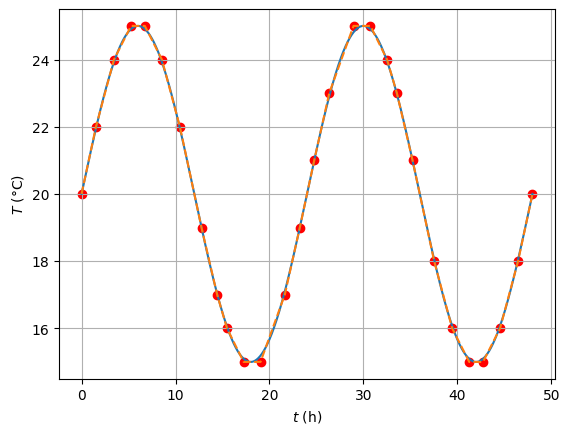

Consigne :
(00) stabilisation à 20°C
(01) rampe vers 22°C de durée 01:32:00
(02) rampe vers 24°C de durée 01:55:00
(03) rampe vers 25°C de durée 01:49:00
(04) rampe vers 25°C de durée 01:28:00
(05) rampe vers 24°C de durée 01:49:00
(06) rampe vers 22°C de durée 01:55:00
(07) rampe vers 19°C de durée 02:18:00
(08) rampe vers 17°C de durée 01:40:00
(09) rampe vers 16°C de durée 01:03:00
(10) rampe vers 15°C de durée 01:46:00
(11) rampe vers 15°C de durée 01:48:00
(12) rampe vers 17°C de durée 02:35:00
(13) rampe vers 19°C de durée 01:36:00
(14) rampe vers 21°C de durée 01:32:00
(15) rampe vers 23°C de durée 01:36:00
(16) rampe vers 25°C de durée 02:35:00
(17) rampe vers 25°C de durée 01:48:00
(18) rampe vers 24°C de durée 01:46:00
(19) rampe vers 23°C de durée 01:03:00
(20) rampe vers 21°C de durée 01:40:00
(21) rampe vers 18°C de durée 02:18:00
(22) rampe vers 16°C de durée 01:55:00
(23) rampe vers 15°C de durée 01:49:00
(24) rampe vers 15°C de durée 01:28:00
(25) rampe vers 16°C de dur

In [5]:
# PLOT
t_plot = np.linspace(0, duration, 1000)
y_plot = f(t_plot)
y_approx_plot = piecewise_approximation(f, t_opt, t_plot)

plt.plot(t_plot / 3600, y_plot, label='Signal d\'entrée')
plt.plot(t_opt / 3600, np.round(f(t_opt)), '--', label='Piecewise approximation')
plt.scatter(t_opt / 3600, np.round(f(t_opt)), color='red', label='Optimal points')
plt.grid()
plt.xlabel('$t$ (h)')
plt.ylabel('$T$ (°C)')
plt.show()

# AFFICHAGE CONSIGNE
def seconds_to_hms(seconds):
    """Convert seconds (float) to 'HH:MM:SS' string."""
    seconds = int(round(seconds))
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

print(f"Consigne :\n(00) stabilisation à {round(f(t_opt[0]))}°C")
for i in range(N-1):
    ti, ti1 = t_opt[i], t_opt[i+1]
    print(f"({(i+1):02d}) rampe vers {round(f(t_opt[i+1]))}°C de durée {seconds_to_hms(ti1 - ti)}")